# Joint Angle Prediction from Distributed Sensing

Using joint angles from motion capture and 4-channel impedance signals recorded with the sensor readout board, predict the four joint angles.
Corresponds to the Section 2 *Joint Angle Monitoring* from [1].

> [1] Brett C. Hannigan, Tyler J. Cuthbert, Chakaveh Ahmadizadeh, and Carlo Menon. Distributed Sensing Along Fibres for Smart Clothing. *Science Advances*. 2023 (In Review).

©2023 ETH Zurich, Brett Hannigan; D-HEST; Biomedical and Mobile Health Technology (BMHT) Lab; Carlo Menon

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, interpolate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from keras import Sequential
from keras import regularizers
from keras.layers import Dense, Flatten, SimpleRNN, GRU, LSTM, Dropout, ReLU, Conv1D, Reshape
from keras.utils import Sequence
from keras.optimizers import Adam, Adagrad, SGD
from keras.losses import CosineSimilarity
from keras.utils import Sequence
from keras.regularizers import L1, L2, L1L2
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.utils import timeseries_dataset_from_array
from datetime import datetime
import tensorflow as tf
import random
print(tf.config.list_physical_devices('GPU'))

[]


### Import Joint Positions and Impedance Signals
Read in CSV files containing joint angles from motion capture and in-phase (I) and quadrature (Q) components of the sensor impedance at each of 4 frequencies.

In [3]:
filenames = ['rep01', 'rep02', 'rep03', 'rep04', 'rep05', 'rep06', 'rep07', 'rep08', 'rep09', 'rep10']
data = pd.DataFrame()
for i_name, name in enumerate(filenames):
    data_file = pd.read_csv(name + "_data.csv", index_col=0)
    data_file.insert(1, 'Run', i_name+1)
    data = pd.concat((data, data_file), ignore_index=True)
X = data[['I_0', 'Q_0', 'I_1', 'Q_1', 'I_2', 'Q_2', 'I_3', 'Q_3']]
Y = data[['LEFT_SHOULDER', 'LEFT_ELBOW', 'LEFT_WRIST']]
group = data.Run
data.head()

,Time,Run,LEFT_SHOULDER,LEFT_ELBOW,LEFT_WRIST,I_0,I_1,I_2,I_3,Q_0,Q_1,Q_2,Q_3
0,0.000000,1,19.006550,40.511662,20.423773,1372.181275,2083.365220,3393.958806,4121.789425,-1824.387354,-4279.759159,-7682.889759,-13921.532330
1,0.041121,1,18.950287,40.446133,20.567822,1384.076086,2132.131927,3442.112526,4176.266968,-1820.331080,-4311.066808,-7711.900554,-13911.047724
2,0.082241,1,18.909916,40.407925,20.665485,1395.234766,2176.886413,3484.403541,4223.705625,-1815.722367,-4338.403345,-7737.297983,-13901.256679
3,0.123362,1,18.885542,40.396049,20.717050,1405.682937,2217.790034,3521.089448,4264.422871,-1810.589198,-4361.946894,-7759.246180,-13892.135363
4,0.164483,1,18.877669,40.407897,20.722919,1415.445825,2255.001310,3552.423160,4298.730286,-1804.959085,-4381.872280,-7777.906186,-13883.660306


### Scaling
Perform Z-score scaling. Note: should probably perform scaling independently per trial, as the global scaling of X and Y is done before splitting into test/validation/train by leave-one-out cross-validation.

In [4]:
ss_X = StandardScaler()
X = X.to_numpy()
ss_Y = StandardScaler()
Y = Y.to_numpy()

### Model Architecture
Instantiate a MLP model mapping the 8 channels of X to the 3 joint angles of Y.
Note: model hyperparameters were tuned on prior dataset with reference joint angles estimated from video camera with MediaPipe.

In [5]:
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Regularizers
reg_l2 = L2(l2=0.10)
reg_l1 = L1(l1=0.01)
reg_l1l2 = L1L2(l1=0.04, l2=0.15)

# Callbacks
save_best_model = ModelCheckpoint(
    datetime.strftime(datetime.now(), 'mlp%Y%m%dT%H%M%S_mlp_{epoch:02d}_{loss:.5f}_{val_loss:.5f}.hdf5'),
    monitor="val_loss",
    verbose=False,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None,
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=250,
    verbose=True,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

# Optimizers
opt_adam = Adam(learning_rate=0.005)
opt_adagrad = Adagrad(learning_rate=0.1)
opt_sgd = SGD(learning_rate=0.1)

# Architecture
mlp = Sequential()
mlp.add(Dense(16, input_dim=8, activation='relu', bias_initializer=Constant(0.1)))
mlp.add(Dense(32, activation='relu', bias_initializer=Constant(0.1), kernel_regularizer=reg_l1l2, bias_regularizer=reg_l1))
mlp.add(Dense(3, activation='linear'))
mlp.compile(loss='mean_squared_error', optimizer=opt_adam, loss_weights = [1, 1, 2])
mlp.summary()

mlp.save('mlp_jointangles.hdf5')

#mlp_history = mlp.fit(X_train, Y_train, batch_size=64, epochs=1000, verbose=True, validation_data=(X_test, Y_test), callbacks=[save_best_model, early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 787
Trainable params: 787
Non-trainable params: 0
_________________________________________________________________


### Perform Leave-One-Out Cross-Validation
May want to use another LOO to split the validation from training data (currently randomly shuffling).

In [8]:
joint_ang_pred = np.zeros(Y.shape)
fold = 0
logo = LeaveOneGroupOut()
rmse_train = np.zeros((len(np.unique(group)), Y.shape[1]))
rmse_test = np.zeros((len(np.unique(group)), Y.shape[1]))
rmse_val = np.zeros((len(np.unique(group)), Y.shape[1]))
r2_train = np.zeros((len(np.unique(group)), Y.shape[1]))
r2_test = np.zeros((len(np.unique(group)), Y.shape[1]))
r2_val = np.zeros((len(np.unique(group)), Y.shape[1]))
for train_index, test_index in logo.split(X, Y, group):
    X_train, X_test = X[train_index,:], X[test_index,:]
    Y_train, Y_test = Y[train_index,:], Y[test_index,:]
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True, random_state=0)
    mlp = load_model('mlp_jointangles.hdf5')
    # mlp = load_model('mlp_jointangles_' + str(fold) + '.hdf5')

    X_train = ss_X.fit_transform(X_train)
    X_val = ss_X.transform(X_val)    
    X_test = ss_X.transform(X_test) 
    Y_train = ss_Y.fit_transform(Y_train)
    Y_val = ss_Y.transform(Y_val)

  
    history = mlp.fit(X_train, Y_train, batch_size=64, epochs=5000, verbose=False, validation_data=(X_val, Y_val), shuffle=True, callbacks=[early_stopping])

    Y_train_pred = ss_Y.inverse_transform(mlp.predict(X_train))
    Y_val_pred = ss_Y.inverse_transform(mlp.predict(X_val))
    Y_test_pred = ss_Y.inverse_transform(mlp.predict(X_test))
    # Y_train_pred = mlp.predict(X_train)
    # Y_val_pred = mlp.predict(ss_X.transform(X_val))
    # Y_test_pred = mlp.predict(ss_X.transform(X_test))
    np.savetxt('Y_train_pred_' + str(fold) + '.csv', Y_train_pred, delimiter=',')
    np.savetxt('Y_test_pred_' + str(fold) + '.csv', Y_test_pred, delimiter=',')
    np.savetxt('Y_train_' + str(fold) + '.csv', ss_Y.inverse_transform(Y_train), delimiter=',')
    np.savetxt('Y_test_' + str(fold) + '.csv', Y_test, delimiter=',')
    rmse_train[fold,:] = mean_squared_error(ss_Y.inverse_transform(Y_train), Y_train_pred, multioutput='raw_values', squared=False)
    rmse_val[fold,:] = mean_squared_error(ss_Y.inverse_transform(Y_val), Y_val_pred, multioutput='raw_values', squared=False)
    rmse_test[fold,:] = mean_squared_error(Y_test, Y_test_pred, multioutput='raw_values', squared=False)
    r2_train[fold,:] = r2_score(ss_Y.inverse_transform(Y_train), Y_train_pred, multioutput='raw_values')
    r2_val[fold,:] = r2_score(ss_Y.inverse_transform(Y_val), Y_val_pred, multioutput='raw_values')
    r2_test[fold,:] = r2_score(Y_test, Y_test_pred, multioutput='raw_values')

    print('Fold ' + str(fold))
    print('Train:')
    print('\tRMSE: {:.3f} deg, {:.3f} deg, {:.3f} deg'.format(*rmse_train[fold,:]))
    print('\tR2: {:.3f}, {:.3f}, {:.3f}'.format(*r2_train[fold,:]))
    print('Validation:')
    print('\tRMSE: {:.3f} deg, {:.3f} deg, {:.3f} deg'.format(*rmse_val[fold,:]))
    print('\tR2: {:.3f}, {:.3f}, {:.3f}'.format(*r2_val[fold,:]))
    print('Test:')
    print('\tRMSE: {:.3f} deg, {:.3f} deg, {:.3f} deg'.format(*rmse_test[fold,:]))
    print('\tR2: {:.3f}, {:.3f}, {:.3f}'.format(*r2_test[fold,:]))
    joint_ang_pred[test_index] = Y_test_pred
    mlp.save('mlp_jointangles_' + str(fold) + '.hdf5')
    fold = fold + 1

Restoring model weights from the end of the best epoch: 616.
Epoch 866: early stopping
129/129 [==============================] - 0s 820us/step
Fold 0
Train:
	RMSE: 4.235 deg, 3.669 deg, 5.671 deg
	R2: 0.962, 0.988, 0.865
Validation:
	RMSE: 4.275 deg, 3.775 deg, 5.626 deg
	R2: 0.962, 0.988, 0.863
Test:
	RMSE: 5.474 deg, 5.089 deg, 11.728 deg
	R2: 0.915, 0.979, 0.665
Restoring model weights from the end of the best epoch: 935.
Epoch 1185: early stopping
147/147 [==============================] - 0s 897us/step
Fold 1
Train:
	RMSE: 4.110 deg, 3.724 deg, 5.751 deg
	R2: 0.964, 0.988, 0.871
Validation:
	RMSE: 4.112 deg, 3.728 deg, 5.832 deg
	R2: 0.964, 0.989, 0.867
Test:
	RMSE: 5.877 deg, 4.743 deg, 5.799 deg
	R2: 0.928, 0.978, 0.840
Restoring model weights from the end of the best epoch: 441.
Epoch 691: early stopping
145/145 [==============================] - 0s 806us/step
Fold 2
Train:
	RMSE: 4.305 deg, 3.875 deg, 5.725 deg
	R2: 0.961, 0.987, 0.873
Validation:
	RMSE: 4.293 deg, 3.813 deg,

### Save Arrays of R<sup>2</sup> and RMSE
These are part of the SI.

In [9]:
np.savetxt('r2_train.csv', r2_train, delimiter=',')
np.savetxt('r2_val.csv', r2_val, delimiter=',')
np.savetxt('r2_test.csv', r2_test, delimiter=',')
np.savetxt('rmse_train.csv', rmse_train, delimiter=',')
np.savetxt('rmse_val.csv', rmse_val, delimiter=',')
np.savetxt('rmse_test.csv', rmse_test, delimiter=',')

### Show Plots of Test Data
#### Shoulder

Shoulder, Test:
	RMSE: 4.639 deg
	R2: 0.954


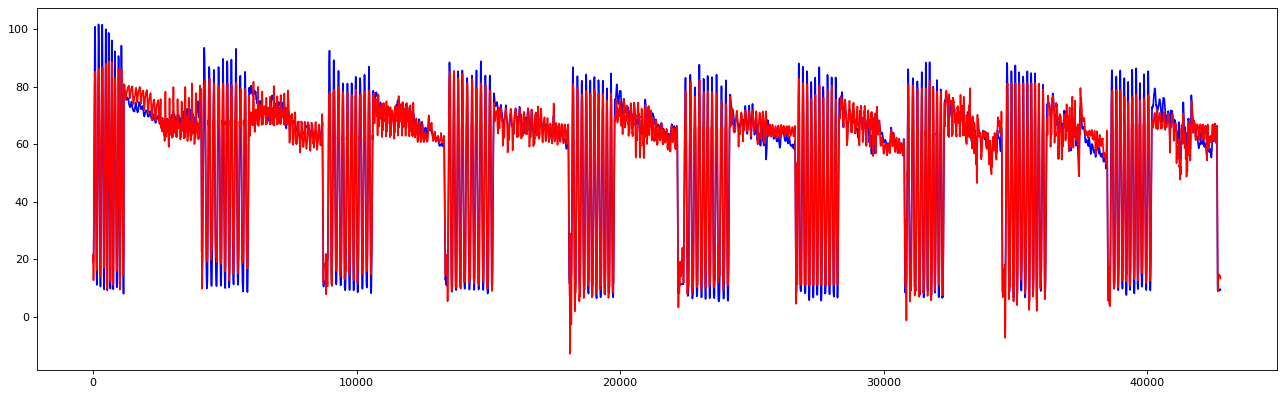

In [10]:
plt.figure(figsize=(20, 6), dpi=80)
# plt.plot(ss_Y.inverse_transform(Y)[:,0], color='blue')
plt.plot(Y[:,0], color='blue')
plt.plot(joint_ang_pred[:,0], color='red')
print('Shoulder, Test:')
print('\tRMSE: {:.3f} deg'.format(mean_squared_error(Y[:,0], joint_ang_pred[:,0], squared=False)))
print('\tR2: {:.3f}'.format(r2_score(Y[:,0], joint_ang_pred[:,0])))

#### Elbow

Elbow, Test:
	RMSE: 1941.194 deg
	R2: -1.876


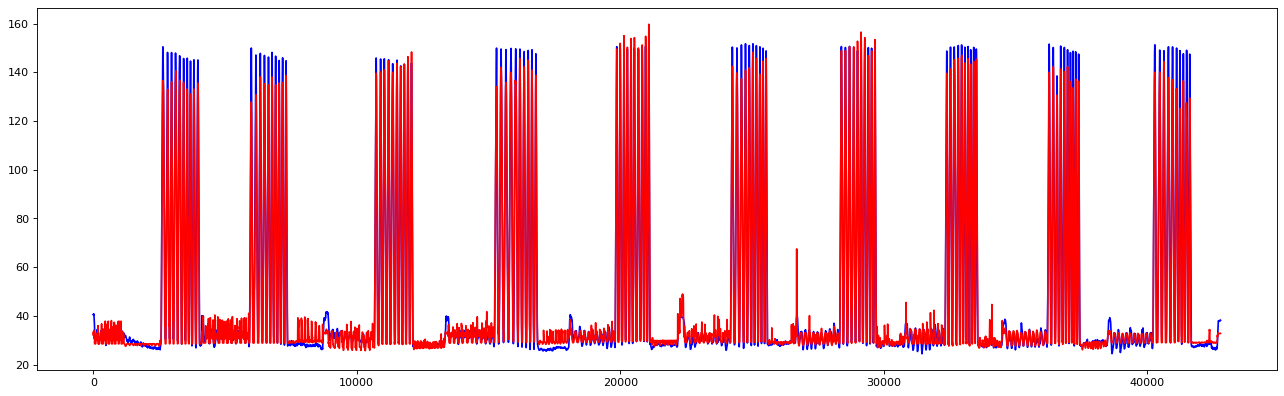

In [11]:
plt.figure(figsize=(20, 6), dpi=80)
# plt.plot(ss_Y.inverse_transform(Y)[:,1], color='blue')
plt.plot(Y[:,1], color='blue')
plt.plot(joint_ang_pred[:,1], color='red')
print('Elbow, Test:')
print('\tRMSE: {:.3f} deg'.format(mean_squared_error(ss_Y.inverse_transform(Y)[:,1], joint_ang_pred[:,1], squared=False)))
print('\tR2: {:.3f}'.format(r2_score(ss_Y.inverse_transform(Y)[:,1], joint_ang_pred[:,1])))

#### Wrist

Wrist, Test:
	RMSE: 292.852 deg
	R2: -0.316


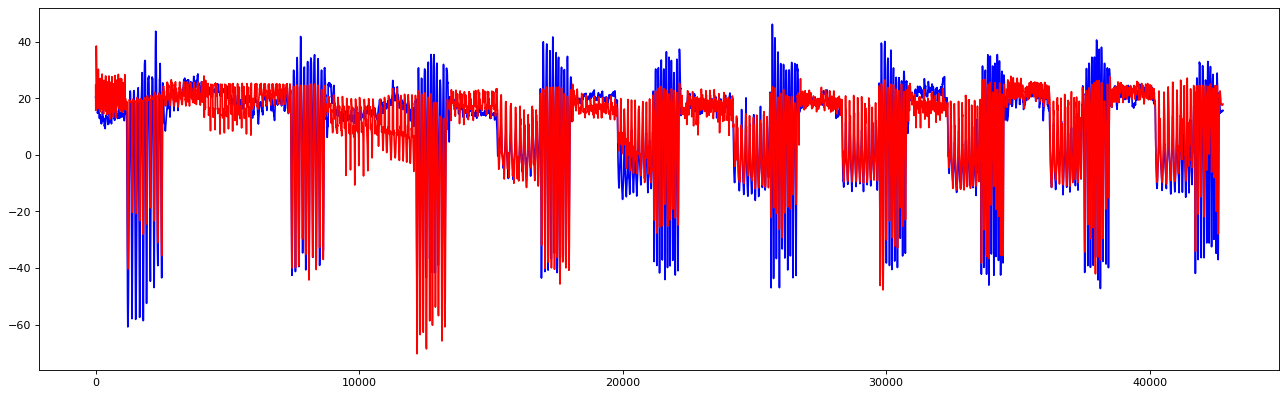

In [12]:
plt.figure(figsize=(20, 6), dpi=80)
plt.plot(Y[:,2], color='blue')
plt.plot(joint_ang_pred[:,2], color='red')
print('Wrist, Test:')
print('\tRMSE: {:.3f} deg'.format(mean_squared_error(ss_Y.inverse_transform(Y)[:,2], joint_ang_pred[:,2], squared=False)))
print('\tR2: {:.3f}'.format(r2_score(ss_Y.inverse_transform(Y)[:,2], joint_ang_pred[:,2])))

### Compile and Save Results

In [13]:
results = pd.DataFrame(joint_ang_pred, columns=['LEFT_SHOULDER_pred', 'LEFT_ELBOW_pred', 'LEFT_WRIST_pred'])
data[['LEFT_SHOULDER', 'LEFT_ELBOW', 'LEFT_WRIST']] = data[['LEFT_SHOULDER', 'LEFT_ELBOW', 'LEFT_WRIST']]

In [14]:
results = pd.concat((data, results), axis=1)
results.to_csv('results.csv', sep=',')